In [1]:
import enspp.bma as bma
import enspp.vis as vis
from optwrf import plots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wrfpywind import data_preprocess as pp
import xarray as xr

No module named 'pyresample'


### Read in the observational data and fit the BMA model

In [2]:
# Read in the observational data
obs = pp.fmt_buoy_wspd(
                       data_path='/share/mzhang/jas983/wrf_data/oshwind/wrfpywind/wrfpywind/data/nyserda_buoy/', 
                       south_dates_str='20190904_20210207', north_dates_str='20190812_20210207', 
                       heights=[20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
                       start_date='12-01-2019', end_date='12-31-2019')

In [3]:
# Specify the forecast initialization time
t_init = '2019-12-08'

In [4]:
# Fit the BMA model using two historical simulations
fit = bma.read_fmt_fit_bma(t_init, obs, n_days=2, datadir='../data/')

### Read in raw WRF ensemble data that will be corrected using BMA
In this first case we will produce a quantile forecast at only the buoy locations.
We call this a `temporal` quantile forecast in the code.

In [5]:
# Read in the ensemble data that you want to correct using BMA
t_init = pd.to_datetime(t_init)
t_end = t_init + pd.DateOffset(days=4)

# Open the xarray Dataset contianing wind speed data for the entire domain 
# note that you must use a `Dataset` object for the `extract_buoy_da` function to work.
ensds = xr.open_dataset(f"../data/ensds_{t_init.strftime('%Y%m%d')}-{t_end.strftime('%d')}.nc")

In [6]:
# Get data only at the buoy locations
ensda = pp.extract_buoy_da(ensds, varname='wspd_wrf', locations=['south', 'north'])

In [7]:
# Get data at only the north buoy at a height of 100m
ensda_slice = ensda.sel(location='north', height=100)

In [8]:
# Apply the BMA fit to the raw ensemble members initialized at t_init
fx_temporal = bma.quantile_fx(fit, ensda_slice, obs, quantiles=np.arange(0.01, 1, 0.01))

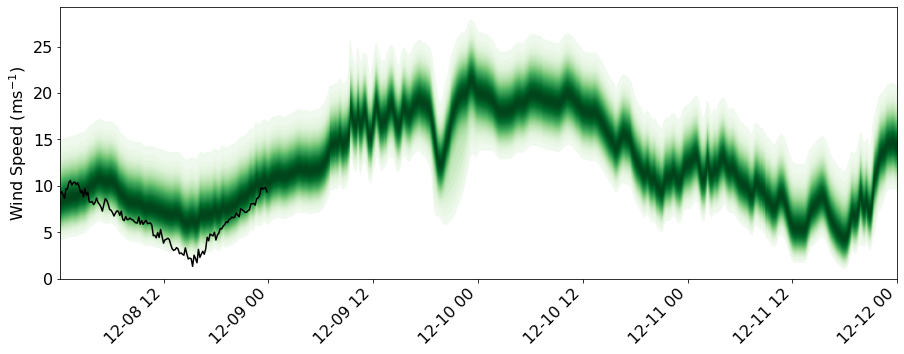

In [9]:
# Visualize the performance of the quantile forecast using a fan plot
# Note that you have to squeeze out the extra dimensions from the observational Dataset for the plotting function to work correctly. 
vis.fan(fx=fx_temporal, obs=obs.sel(location='north', height=100).squeeze(), 
    p1=None, p2=None, t_issue=t_init, n_days=1, fx_res='10T', title=None, 
    percentile_vals=None, fig_w=15, ylab=True, ylab_txt='Wind Speed (ms$^{-1}$)', 
    show_fig=True, save_fig=False, fig_path='../data/plots/fan_plot.png')

## Now, we will produce a quantile forcast for the full domain.
We call this a `spatial` quantile forecast in the code.

In [10]:
# Select only the height and time that we are interested in 
# -- when creating a spatial forecast, we only provide a single lead time.
# Note that you have to use a `slice()` operation to presever the `Time` dimension.
wrfda_slice = ensds.wspd_wrf.sel(height=100, Time=slice('2019-12-08 14:40', '2019-12-08 14:40'))


In [11]:
# Extract the quantiles using the BMA test fit using the type="spatial" keyword argument.
# This takes ~10min for 99 quantiles, so I'm only calculating three quantiles here.
fx_spatial = bma.quantile_fx(fit, wrfda_slice, obs, gamma_bma=None, quantiles=np.array([0.1, 0.5, 0.9]), type='spatial')

In [12]:
wrfds = xr.open_dataset('/share/mzhang/jas983/wrf_data/met4ene/wrfout/ARW/offshore_wind/no_wfp/2020-02-04_28mp4lw4sw2lsm5pbl1cu/ow_wrfout_d03_2020-02-04-2020-02-12')

# Get the start_date and create the date string
datestr = str(wrfda_slice.Time.dt.strftime('%Y-%m-%d %H:%M')[0].values)

# To start, we need to get the WRF map projection information (a Lambert Conformal grid),
# and find the domain boundaries in this projection.
# NOTE: this task MUST occurr before we regrid the WRF variables or the coordinates change and become incompatible.
wrf_cartopy_proj = plots.get_wrf_proj(wrfds, 'temp')
proj_bounds = plots.get_domain_boundary(wrfds, wrf_cartopy_proj)

Variables {'lat': 'XLAT', 'lon': 'XLONG'} cannot be renamed, those on the left are not in this dataset.


/home/jas983/anaconda3/envs/enspp/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'pressure' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


/home/jas983/anaconda3/envs/enspp/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/jas983/anaconda3/envs/enspp/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/jas983/anaconda3/envs/enspp/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


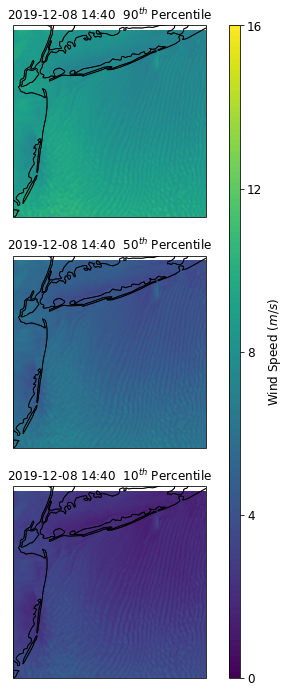

In [13]:
# Set the figure size
fig = plt.figure(figsize=(4, 12))
# Set the GeoAxes to the projection used by WRF
ax_wrf1 = fig.add_subplot(3, 1, 1, projection=wrf_cartopy_proj)
ax_wrf2 = fig.add_subplot(3, 1, 2, projection=wrf_cartopy_proj)
ax_wrf3 = fig.add_subplot(3, 1, 3, projection=wrf_cartopy_proj)

vis.quantile_cn(fx_spatial, 90, ax_wrf1, proj_bounds, t_idx=0, add_cbar=False, plot_buoy=False)
vis.quantile_cn(fx_spatial, 50, ax_wrf2, proj_bounds, t_idx=0, add_cbar=False, plot_buoy=False)
cn = vis.quantile_cn(fx_spatial, 10, ax_wrf3, proj_bounds, t_idx=0, add_cbar=False, plot_buoy=False)

# Add a color bar to the full plot
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.90, 0.125, 0.04, 0.755])  # [left, bottom, width, height]
cbar_ticks=(0, 4, 8, 12, 16)
cbar_tick_labels=[0, 4, 8, 12, 16]
cbar = fig.colorbar(cn, cax=cbar_ax, ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_tick_labels, fontsize=12)
cbar.set_label(label='Wind Speed ($m/s$)', size=12)

# plt.savefig(f'../data/plots/multiquantile_map_{datestr}.png', dpi=300, transparent=True, bbox_inches='tight')

plt.show()